Here we parse the MGB3 and report the inter annotator disagreement for test set

In [1]:
import subprocess
import re
import sys
import codecs
import numpy as np
import os


_unicode = u"\u0622\u0624\u0626\u0628\u062a\u062c\u06af\u062e\u0630\u0632\u0634\u0636\u0638\u063a\u0640\u0642\u0644\u0646\u0648\u064a\u064c\u064e\u0650\u0652\u0670\u067e\u0686\u0621\u0623\u0625\u06a4\u0627\u0629\u062b\u062d\u062f\u0631\u0633\u0635\u0637\u0639\u0641\u0643\u0645\u0647\u0649\u064b\u064d\u064f\u0651\u0671"
_buckwalter = u"|&}btjGx*z$DZg_qlnwyNaio`PJ'><VApvHdrsSTEfkmhYFKu~{"

_toUTF8dMap = {ord(b):a for a,b in zip(_unicode, _buckwalter)}
_toBWMap = {ord(b):a for a,b in zip(_buckwalter,_unicode)}

def toUTF8(s):
  return s.translate(_toUTF8dMap)

def toBUCKWALTER(s):
  return s.translate(_toBWMap)

_preNormalize = u"pY><|\u0629\u0649\u0623\u0625\u0622"
_postNormalize = u"hyAAA\u0647\u064a\u0627\u0627\u0627"
_toNormalize = {ord(b):a for a,b in zip(_postNormalize,_preNormalize)}

def normalizeText(s):
  return s.translate(_toNormalize)

transcriberList = ["Alaa", "Ali", "Omar", "Mohamed"]


In [2]:
def removeVowels (inFile, outFile): 
    _f1 = codecs.open (inFile,'r',encoding='utf-8')
    _f2 = codecs.open (outFile,'w',encoding='utf-8') 
    for line in _f1: _f2.write("%s" % line)
    _f2.close()

In [3]:
def convert_to_BW (inFile, outFile): 
    _f1 = codecs.open (inFile,'r',encoding='utf-8')
    _f2 = codecs.open (outFile,'w',encoding='utf-8') 
    for line in _f1: _f2.write("%s" % toBUCKWALTER (line))
    _f2.close()

In [4]:
def removeFirstColumn (inFile,outFile):
    _f1 = codecs.open (inFile,'r',encoding='utf-8')
    _f2 = codecs.open (outFile,'w',encoding='utf-8') 
    for line in _f1: 
        line2 = " ".join(line.split(' ')[1:])
        line22 = re.sub(r"[#@:!]", "", line2)
        line3 = toBUCKWALTER (line22)
        _f2.write("%s" % line3)
    _f2.close()
#we also convert it to BW for easy processing       

In [5]:
def normalize (inFile, outFile): 
   my_list=[x.split(' ')[:] for x in open(inFile).readlines()]
   with open( outFile, 'w') as f:
      for item in my_list:
        line = normalizeText(" ".join(item))
        f.write("%s" % line)

In [6]:
def reportWER (inFile1,inFile2,_NORMALIZE1=False,_NORMALIZE2=False):
    
    fianl_file1="tmp1.2"
    fianl_file2="tmp2.2"
    
    #remove first column and volelization from first file
    removeFirstColumn (inFile1,"tmp1.1")
    removeVowels ("tmp1.1","tmp1.2")
    
    
    #remove second column and volelization from first file
    removeFirstColumn (inFile2,"tmp2.1")
    removeVowels ("tmp2.1","tmp2.2")
    
    if _NORMALIZE1:
        normalize ("tmp1.2","tmp1.3")
        fianl_file1="tmp1.3"
        
    if _NORMALIZE2:
        normalize ("tmp2.2","tmp2.3")
        fianl_file2="tmp2.3"
        
        
    
    p = subprocess.Popen(["wer", fianl_file1, fianl_file2], stdout=subprocess.PIPE)
    output, err = p.communicate()
    
    output.decode("utf-8")
    output1=str(output, 'utf-8')
    
    wer=float((output1.split('\n')[1].split('%')[0].split(':')[1]))
    
    os.remove("tmp1.1")
    os.remove("tmp1.2")
    if _NORMALIZE1: os.remove("tmp1.3")
    os.remove("tmp2.1")
    os.remove("tmp2.2")
    if _NORMALIZE2: os.remove("tmp2.3")
   
    return (wer)


In [7]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, _file, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                         ):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.clf()
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(_file, format='pdf')
    plt.show()


In [8]:
def buildConf (data="test",name="text_noverlap.bw",_NORMALIZE=False):

    mat = np.zeros([len(transcriberList), len(transcriberList)], dtype = int) 

    for idx1, transcriber1 in enumerate(transcriberList):
        for idx2, transcriber2 in enumerate(transcriberList):
            file1="./"+data+'/'+transcriber1+"/"+name
            file2="./"+data+'/'+transcriber2+"/"+name
            _WER = reportWER(file1,file2,_NORMALIZE,_NORMALIZE)
            print ('comparing:', transcriber1,transcriber2,':', _WER, '% WER')
            mat[idx1][idx2] = _WER
    print (mat)
    outFile=name+'.'+str(_NORMALIZE)+'.pdf'
    plot_confusion_matrix(mat, outFile, classes=transcriberList , title='inter annotator disagreement')
  

### Here we build the confusion matrix for the original text with and without normalization 

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 21.861 % WER
comparing: Alaa Omar : 14.185 % WER
comparing: Alaa Mohamed : 17.159 % WER
comparing: Ali Alaa : 21.783 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 19.227 % WER
comparing: Ali Mohamed : 18.057 % WER
comparing: Omar Alaa : 14.044 % WER
comparing: Omar Ali : 19.103 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 9.498 % WER
comparing: Mohamed Alaa : 17.142 % WER
comparing: Mohamed Ali : 18.103 % WER
comparing: Mohamed Omar : 9.583 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 21 14 17]
 [21  0 19 18]
 [14 19  0  9]
 [17 18  9  0]]
Confusion matrix, without normalization


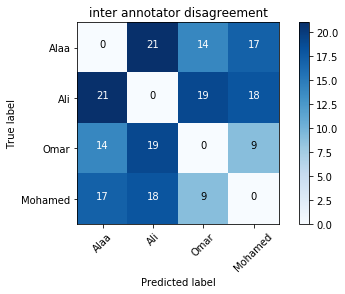

In [9]:
buildConf (data="test",name="text_noverlap.bw",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 17.397 % WER
comparing: Alaa Omar : 11.417 % WER
comparing: Alaa Mohamed : 14.718 % WER
comparing: Ali Alaa : 17.335 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 16.187 % WER
comparing: Ali Mohamed : 15.174 % WER
comparing: Omar Alaa : 11.303 % WER
comparing: Omar Ali : 16.083 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 8.433 % WER
comparing: Mohamed Alaa : 14.703 % WER
comparing: Mohamed Ali : 15.213 % WER
comparing: Mohamed Omar : 8.509 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 17 11 14]
 [17  0 16 15]
 [11 16  0  8]
 [14 15  8  0]]
Confusion matrix, without normalization


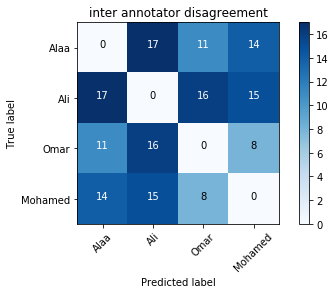

In [10]:
buildConf (data="test",name="text_noverlap.bw",_NORMALIZE=True)

### Here we build the confusion matrix for the madamira text with and without normalization

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 16.71 % WER
comparing: Alaa Omar : 10.52 % WER
comparing: Alaa Mohamed : 13.945 % WER
comparing: Ali Alaa : 16.65 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 15.022 % WER
comparing: Ali Mohamed : 14.631 % WER
comparing: Omar Alaa : 10.416 % WER
comparing: Omar Ali : 14.926 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 7.651 % WER
comparing: Mohamed Alaa : 13.931 % WER
comparing: Mohamed Ali : 14.668 % WER
comparing: Mohamed Omar : 7.72 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 16 10 13]
 [16  0 15 14]
 [10 14  0  7]
 [13 14  7  0]]
Confusion matrix, without normalization


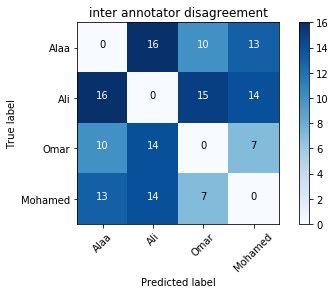

In [11]:
buildConf (data="test",name="text_noverlap.bw.madaDiac",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 16.668 % WER
comparing: Alaa Omar : 10.487 % WER
comparing: Alaa Mohamed : 13.915 % WER
comparing: Ali Alaa : 16.609 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 15.009 % WER
comparing: Ali Mohamed : 14.576 % WER
comparing: Omar Alaa : 10.383 % WER
comparing: Omar Ali : 14.913 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 7.601 % WER
comparing: Mohamed Alaa : 13.901 % WER
comparing: Mohamed Ali : 14.614 % WER
comparing: Mohamed Omar : 7.67 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 16 10 13]
 [16  0 15 14]
 [10 14  0  7]
 [13 14  7  0]]
Confusion matrix, without normalization


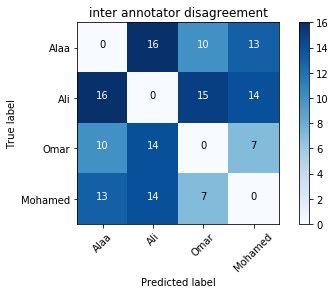

In [12]:
buildConf (data="test",name="text_noverlap.bw.madaDiac",_NORMALIZE=True)

This section shows how to comapre two files, you can normalize one file only or both as shown below

### Here is an example to comapre two files, first one normalized and second file without normalization

In [13]:
wer1=reportWER("./test/Alaa/text_noverlap.bw","./test/Alaa/text_noverlap.bw",True,False)
wer2=reportWER("./test/Alaa/text_noverlap.bw.madaDiac","./test/Alaa/text_noverlap.bw.madaDiac",True,False)
print ('WER: between test Alaa original with and without nomrlization: ', wer1, '%')
print ('WER: between test Alaa MADA with and without nomrlization: ', wer2, '%')

WER: between test Alaa original with and without nomrlization:  31.015 %
WER: between test Alaa MADA with and without nomrlization:  28.342 %


### Here we compare two files from the system submissions:

In [14]:
wer1=reportWER("./test/Alaa/text_noverlap.bw","./test/AALTO.tra",False,False)
wer2=reportWER("./test/Alaa/text_noverlap.bw","./test/AALTO.tra",True,True)
print ('WER: MGB-3 best system Aalto : ', wer1, '%')
print ('WER: MGB-3 best system Aalto with nomrlization: ', wer2, '%')

WER: MGB-3 best system Aalto :  39.275 %
WER: MGB-3 best system Aalto with nomrlization:  37.772 %


comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 21.861 % WER
comparing: Alaa Omar : 14.185 % WER
comparing: Alaa Mohamed : 17.159 % WER
comparing: Ali Alaa : 21.783 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 19.227 % WER
comparing: Ali Mohamed : 18.057 % WER
comparing: Omar Alaa : 14.044 % WER
comparing: Omar Ali : 19.103 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 9.498 % WER
comparing: Mohamed Alaa : 17.142 % WER
comparing: Mohamed Ali : 18.103 % WER
comparing: Mohamed Omar : 9.583 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 21 14 17]
 [21  0 19 18]
 [14 19  0  9]
 [17 18  9  0]]
Confusion matrix, without normalization


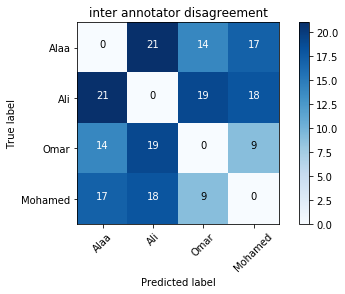

In [15]:
from distutils.dir_util import copy_tree
copy_tree("./Analysis_full/Machine/Mo", "./Analysis_full/Human/Mo")
_type="txt"
buildConf  (data="Analysis_full/Human/",name="txt",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 17.397 % WER
comparing: Alaa Omar : 11.417 % WER
comparing: Alaa Mohamed : 14.718 % WER
comparing: Ali Alaa : 17.335 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 16.187 % WER
comparing: Ali Mohamed : 15.174 % WER
comparing: Omar Alaa : 11.303 % WER
comparing: Omar Ali : 16.083 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 8.433 % WER
comparing: Mohamed Alaa : 14.703 % WER
comparing: Mohamed Ali : 15.213 % WER
comparing: Mohamed Omar : 8.509 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 17 11 14]
 [17  0 16 15]
 [11 16  0  8]
 [14 15  8  0]]
Confusion matrix, without normalization


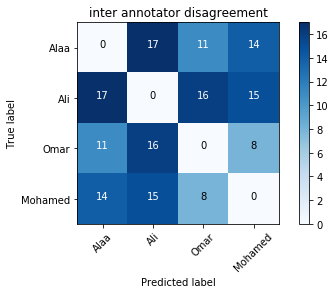

In [16]:
buildConf  (data="Analysis_full/Human/",name="txt",_NORMALIZE=True)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 17.397 % WER
comparing: Alaa Omar : 11.417 % WER
comparing: Alaa Mohamed : 14.718 % WER
comparing: Ali Alaa : 17.335 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 16.187 % WER
comparing: Ali Mohamed : 15.174 % WER
comparing: Omar Alaa : 11.303 % WER
comparing: Omar Ali : 16.083 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 8.433 % WER
comparing: Mohamed Alaa : 14.703 % WER
comparing: Mohamed Ali : 15.213 % WER
comparing: Mohamed Omar : 8.509 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 17 11 14]
 [17  0 16 15]
 [11 16  0  8]
 [14 15  8  0]]
Confusion matrix, without normalization


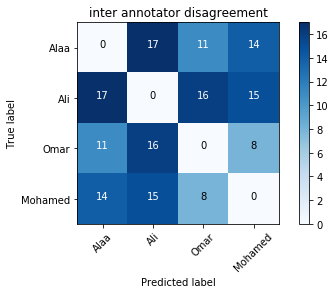

In [17]:
buildConf  (data="Analysis_full/Human/",name="txt.alif-ya-tamar.norm",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 17.397 % WER
comparing: Alaa Omar : 11.417 % WER
comparing: Alaa Mohamed : 14.718 % WER
comparing: Ali Alaa : 17.335 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 16.187 % WER
comparing: Ali Mohamed : 15.174 % WER
comparing: Omar Alaa : 11.303 % WER
comparing: Omar Ali : 16.083 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 8.433 % WER
comparing: Mohamed Alaa : 14.703 % WER
comparing: Mohamed Ali : 15.213 % WER
comparing: Mohamed Omar : 8.509 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 17 11 14]
 [17  0 16 15]
 [11 16  0  8]
 [14 15  8  0]]
Confusion matrix, without normalization


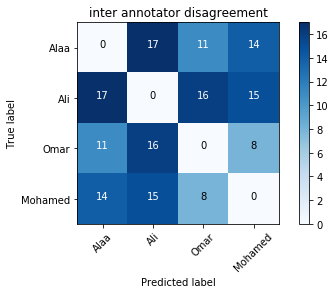

In [18]:
buildConf  (data="Analysis_full/Human/",name="txt.alif-ya-tamar.norm",_NORMALIZE=True)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 16.611 % WER
comparing: Alaa Omar : 10.413 % WER
comparing: Alaa Mohamed : 13.841 % WER
comparing: Ali Alaa : 16.553 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 14.9 % WER
comparing: Ali Mohamed : 14.548 % WER
comparing: Omar Alaa : 10.31 % WER
comparing: Omar Ali : 14.805 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 7.545 % WER
comparing: Mohamed Alaa : 13.827 % WER
comparing: Mohamed Ali : 14.585 % WER
comparing: Mohamed Omar : 7.613 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 16 10 13]
 [16  0 14 14]
 [10 14  0  7]
 [13 14  7  0]]
Confusion matrix, without normalization


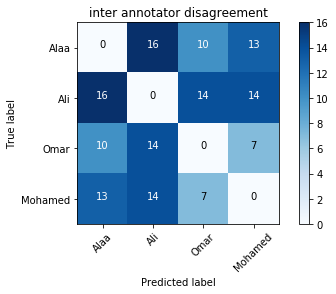

In [20]:
buildConf  (data="Analysis_full/Human/",name="txt.D0.tok",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 16.522 % WER
comparing: Alaa Omar : 10.33 % WER
comparing: Alaa Mohamed : 13.764 % WER
comparing: Ali Alaa : 16.463 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 14.822 % WER
comparing: Ali Mohamed : 14.45 % WER
comparing: Omar Alaa : 10.228 % WER
comparing: Omar Ali : 14.727 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 7.454 % WER
comparing: Mohamed Alaa : 13.75 % WER
comparing: Mohamed Ali : 14.487 % WER
comparing: Mohamed Omar : 7.521 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 16 10 13]
 [16  0 14 14]
 [10 14  0  7]
 [13 14  7  0]]
Confusion matrix, without normalization


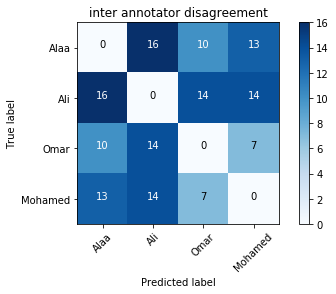

In [21]:
buildConf  (data="Analysis_full/Human/",name="txt.D0.tok",_NORMALIZE=True)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 13.86 % WER
comparing: Alaa Omar : 8.823 % WER
comparing: Alaa Mohamed : 11.829 % WER
comparing: Ali Alaa : 13.811 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 12.394 % WER
comparing: Ali Mohamed : 12.144 % WER
comparing: Omar Alaa : 8.735 % WER
comparing: Omar Ali : 12.314 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 6.733 % WER
comparing: Mohamed Alaa : 11.817 % WER
comparing: Mohamed Ali : 12.175 % WER
comparing: Mohamed Omar : 6.794 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 13  8 11]
 [13  0 12 12]
 [ 8 12  0  6]
 [11 12  6  0]]
Confusion matrix, without normalization


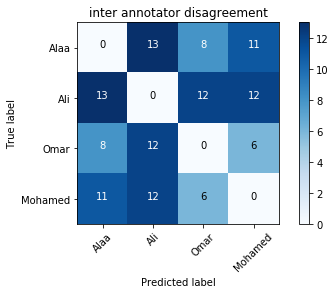

In [22]:
buildConf  (data="Analysis_full/Human/",name="txt.lemma",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 13.795 % WER
comparing: Alaa Omar : 8.801 % WER
comparing: Alaa Mohamed : 11.799 % WER
comparing: Ali Alaa : 13.746 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 12.337 % WER
comparing: Ali Mohamed : 12.094 % WER
comparing: Omar Alaa : 8.713 % WER
comparing: Omar Ali : 12.258 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 6.707 % WER
comparing: Mohamed Alaa : 11.787 % WER
comparing: Mohamed Ali : 12.125 % WER
comparing: Mohamed Omar : 6.767 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[ 0 13  8 11]
 [13  0 12 12]
 [ 8 12  0  6]
 [11 12  6  0]]
Confusion matrix, without normalization


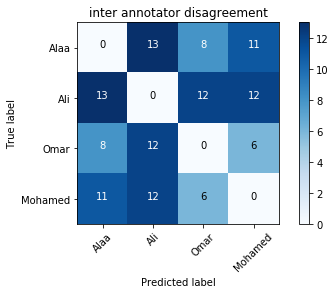

In [23]:
buildConf  (data="Analysis_full/Human/",name="txt.lemma",_NORMALIZE=True)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 7.42 % WER
comparing: Alaa Omar : 4.859 % WER
comparing: Alaa Mohamed : 6.246 % WER
comparing: Ali Alaa : 7.429 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 6.427 % WER
comparing: Ali Mohamed : 6.388 % WER
comparing: Omar Alaa : 4.829 % WER
comparing: Omar Ali : 6.38 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 3.603 % WER
comparing: Mohamed Alaa : 6.248 % WER
comparing: Mohamed Ali : 6.383 % WER
comparing: Mohamed Omar : 3.627 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[0 7 4 6]
 [7 0 6 6]
 [4 6 0 3]
 [6 6 3 0]]
Confusion matrix, without normalization


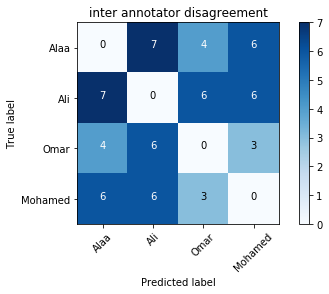

In [24]:
buildConf  (data="Analysis_full/Human/",name="txt.char.tok",_NORMALIZE=False)

comparing: Alaa Alaa : 0.0 % WER
comparing: Alaa Ali : 6.356 % WER
comparing: Alaa Omar : 4.154 % WER
comparing: Alaa Mohamed : 5.551 % WER
comparing: Ali Alaa : 6.363 % WER
comparing: Ali Ali : 0.0 % WER
comparing: Ali Omar : 5.666 % WER
comparing: Ali Mohamed : 5.562 % WER
comparing: Omar Alaa : 4.128 % WER
comparing: Omar Ali : 5.625 % WER
comparing: Omar Omar : 0.0 % WER
comparing: Omar Mohamed : 2.99 % WER
comparing: Mohamed Alaa : 5.553 % WER
comparing: Mohamed Ali : 5.558 % WER
comparing: Mohamed Omar : 3.009 % WER
comparing: Mohamed Mohamed : 0.0 % WER
[[0 6 4 5]
 [6 0 5 5]
 [4 5 0 2]
 [5 5 3 0]]
Confusion matrix, without normalization


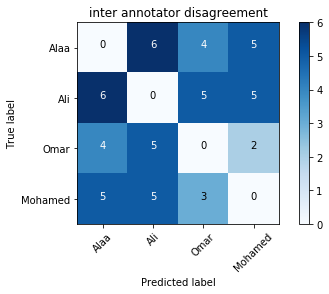

In [25]:
buildConf  (data="Analysis_full/Human/",name="txt.char.tok",_NORMALIZE=True)